# DDPG implementation on Bipedalwalker

## 1. Import libraries

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## 2. Classes for Critic and Actor networks

In [ ]:
class CriticNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(CriticNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber
        
        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, inputs):
        state, action = inputs
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(ActorNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber

        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.mu = Dense(self.actionsNumber, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

## 3. Buffer Class

In [ ]:
class ReplayBuffer():
    def __init__(self, maxSize, inputShape, actionsNumber):
        self.memorySize = maxSize
        self.memoryCounter = 0
        # Initialise replay buffer (s, a, r, s')
        self.stateBuffer = np.zeros((self.memorySize, *inputShape))
        self.actionBuffer = np.zeros((self.memorySize, actionsNumber))
        self.rewardBuffer = np.zeros(self.memorySize)
        self.newStateBuffer = np.zeros((self.memorySize, *inputShape))
        self.terminalBuffer = np.zeros(self.memorySize, dtype=np.bool_)

    def transition(self, state, action, reward, nextState, done):
        index = self.memoryCounter % self.memorySize
        self.stateBuffer[index] = state
        self.actionBuffer[index] = action
        self.rewardBuffer[index] = reward
        self.newStateBuffer[index] = nextState
        self.terminalBuffer[index] = done

        self.memoryCounter += 1
        return None

    def sample(self, batchSize):
        maxMemory = min(self.memoryCounter, self.memorySize)
        batchNumber = np.random.choice(maxMemory, batchSize)

        states = self.stateBuffer[batchNumber]
        actions = self.actionBuffer[batchNumber]
        rewards = self.rewardBuffer[batchNumber]
        nextStates = self.newStateBuffer[batchNumber]
        dones = self.terminalBuffer[batchNumber]

        return states, actions, rewards, nextStates, dones

## 4. Agent Class

In [ ]:
class Agent:

    def __init__(self, inputShape=None, alpha=0.0001, beta=0.001, env=None, gamma=0.99, actionsNumber=2, maxSize=1000000, tau=0.001, fc1=400, fc2=300, batchSize=64, noise=0.1, checkpoint='model_checkpoint/ddpg/'):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(maxSize, inputShape, actionsNumber)
        self.batchSize = batchSize
        self.actionsNumber = actionsNumber
        self.noise = noise
        self.maxAction = env.action_space.high[0]
        self.minAction = env.action_space.low[0]
        self.checkpoint = checkpoint

        # Initialise networks
        self.actor = ActorNetwork(actionsNumber=actionsNumber,fc1Dim=fc1, fc2Dim=fc2)
        self.critic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetActor = ActorNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetCritic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)

        # Compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.targetActor.compile(optimizer=Adam(learning_rate=alpha))
        self.targetCritic.compile(optimizer=Adam(learning_rate=beta))

        self.updateParameters(tau=1)

    def updateParameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.targetActor.weights

        # Soft Copy 
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetActor.set_weights(weights)

        weights = []
        targets = self.targetCritic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetCritic.set_weights(weights)

    def transition(self, state, action, reward, nextState, done):
        self.memory.transition(state, action, reward, nextState, done)

    def save(self):
        print('')
        print('save models')
        self.actor.save(self.checkpoint+'actor')
        self.targetActor.save(self.checkpoint+'targetActor')
        self.critic.save(self.checkpoint+'critic')
        self.targetCritic.save(self.checkpoint+'targetCritic')

    def load(self):
        print('')
        print('load models')
        self.actor = keras.models.load_model(self.checkpoint+'actor')
        self.targetActor = keras.models.load_model(self.checkpoint+'targetActor')
        self.critic = keras.models.load_model(self.checkpoint+'critic')
        self.targetCritic = keras.models.load_model(self.checkpoint+'targetCritic')

    def chooseAction(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            # adding gussian noise to every action selection
            actions += tf.random.normal(shape=[self.actionsNumber], mean=0.0, stddev=self.noise)
        # max action when action is more than one
        actions = tf.clip_by_value(actions, self.minAction, self.maxAction)
        return actions[0]

    def learn(self):
        if self.memory.memoryCounter < self.batchSize:
            return None

        # Sampling state action reward and nextstate
        state, action, reward, nextState, done = self.memory.sample(self.batchSize)
        # Batches
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        nextStates = tf.convert_to_tensor(nextState, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        # Gradient for critic network
        with tf.GradientTape() as tape:
            targetActions = self.targetActor(nextStates)
            nextCriticValue = tf.squeeze(self.targetCritic((nextStates, targetActions)), 1)
            criticValue = tf.squeeze(self.critic((states, actions)), 1)
            target = rewards + self.gamma*nextCriticValue*(1-done)
            criticLoss = keras.losses.MSE(target, criticValue)
        params = self.critic.trainable_variables
        gradients = tape.gradient(criticLoss, params)
        self.critic.optimizer.apply_gradients(zip(gradients, params))
        # Gradient for actor network
        with tf.GradientTape() as tape:
            newPolicyActions = self.actor(states)
            actorLoss = -self.critic((states, newPolicyActions))
            actorLoss = tf.math.reduce_mean(actorLoss)
        params = self.actor.trainable_variables
        gradients = tape.gradient(actorLoss, params)
        self.actor.optimizer.apply_gradients(zip(gradients, params))

        self.updateParameters()

## 5. Function for plotting learning curve

In [ ]:
# def manage_memory():
#     gpus = tf.config.list_physical_devices('GPU')
#     if gpus:
#         try:
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#         except RuntimeError as e:
#             print(e)

def plot(x, scores, plotFile):
    avgScore = np.zeros(len(scores))
    for i in range(len(avgScore)):
        avgScore[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, avgScore)
    plt.title('Moving average of previous 100 scores')
    plt.savefig(plotFile)

## 6. Run


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 0 score -102.3 avg score -102.3
episode 1 score -117.5 avg score -109.9
episode 2 score -169.1 avg score -129.6
episode 3 score -160.9 avg score -137.4
episode 4 score -147.9 avg score -139.5
episode 5 score -102.1 avg score -133.3
episode 6 score -160.3 avg score -137.1
episode 7 score -145.7 avg score -138.2
episode 8 score -102.9 avg score -134.3
episode 9 score -103.2 avg score -131.2
episode 10 score -103.0 avg score -128.6
episode 11 score -103.7 avg score -126.5
episode 12 score -132.3 avg score -127.0
episode 13 score -119.4 avg score -126.4
episode 14 score -124.9 avg score -126.3
episode 15 score -139.0 avg score -127.1
episode 16 score -119.5 avg score -126.7
episod

episode 191 score -105.3 avg score -111.7
episode 192 score -115.4 avg score -111.7
episode 193 score -128.3 avg score -111.9
episode 194 score -106.8 avg score -111.8
episode 195 score -105.3 avg score -111.7
episode 196 score -104.7 avg score -111.7
episode 197 score -120.2 avg score -111.8
episode 198 score -108.0 avg score -111.7
episode 199 score -108.9 avg score -111.5
episode 200 score -105.9 avg score -111.5
episode 201 score -127.3 avg score -111.5
episode 202 score -103.6 avg score -111.5
episode 203 score -105.7 avg score -111.5
episode 204 score -109.7 avg score -111.4
episode 205 score -103.5 avg score -111.3
episode 206 score -108.0 avg score -111.1
episode 207 score -112.7 avg score -110.9
episode 208 score -108.0 avg score -110.9
episode 209 score -105.0 avg score -110.8
episode 210 score -122.7 avg score -111.0
episode 211 score -131.0 avg score -111.2
episode 212 score -104.5 avg score -111.2
episode 213 score -103.8 avg score -111.1
episode 214 score -104.6 avg score

episode 387 score -105.5 avg score -111.3
episode 388 score -104.2 avg score -111.3
episode 389 score -104.8 avg score -111.3
episode 390 score -107.5 avg score -110.8
episode 391 score -106.4 avg score -110.8
episode 392 score -103.0 avg score -110.8
episode 393 score -104.3 avg score -110.8
episode 394 score -102.8 avg score -109.5
episode 395 score -105.0 avg score -109.5
episode 396 score -106.9 avg score -109.5
episode 397 score -103.4 avg score -109.5
episode 398 score -103.2 avg score -109.5
episode 399 score -106.5 avg score -109.5
episode 400 score -105.9 avg score -109.5
episode 401 score -112.0 avg score -109.6
episode 402 score -107.8 avg score -109.6
episode 403 score -106.5 avg score -109.7
episode 404 score -106.1 avg score -109.7
episode 405 score -103.9 avg score -109.7
episode 406 score -108.2 avg score -109.8
episode 407 score -109.0 avg score -109.8
episode 408 score -103.7 avg score -109.8
episode 409 score -103.0 avg score -109.8
episode 410 score -103.3 avg score

episode 583 score -107.8 avg score -108.7
episode 584 score -103.0 avg score -108.7
episode 585 score -127.3 avg score -108.9
episode 586 score -106.6 avg score -108.9
episode 587 score -102.2 avg score -108.9
episode 588 score -91.4 avg score -108.8
episode 589 score -107.7 avg score -108.8
episode 590 score -129.4 avg score -109.0
episode 591 score -129.4 avg score -109.3
episode 592 score -131.9 avg score -109.6
episode 593 score -147.0 avg score -110.0
episode 594 score -140.6 avg score -110.0
episode 595 score -128.2 avg score -110.3
episode 596 score -128.5 avg score -110.5
episode 597 score -141.6 avg score -110.9
episode 598 score -134.6 avg score -111.1
episode 599 score -120.2 avg score -111.1
episode 600 score -108.9 avg score -111.1
episode 601 score -108.4 avg score -111.1
episode 602 score -117.4 avg score -111.2
episode 603 score -137.9 avg score -111.4
episode 604 score -148.5 avg score -111.8
episode 605 score -138.3 avg score -112.1
episode 606 score -122.2 avg score 

episode 779 score -132.0 avg score -108.7
episode 780 score -170.9 avg score -109.2
episode 781 score -143.3 avg score -109.4
episode 782 score -141.6 avg score -109.8
episode 783 score -147.1 avg score -110.1
episode 784 score -145.1 avg score -110.3
episode 785 score -134.9 avg score -110.5
episode 786 score -137.0 avg score -110.7
episode 787 score -152.6 avg score -111.1
episode 788 score -135.6 avg score -111.4
episode 789 score -133.8 avg score -111.7
episode 790 score -126.0 avg score -111.8
episode 791 score -145.0 avg score -112.2
episode 792 score -142.7 avg score -112.5
episode 793 score -91.1 avg score -112.2
episode 794 score -111.2 avg score -112.2
episode 795 score -159.2 avg score -112.7
episode 796 score -164.5 avg score -113.2
episode 797 score -112.5 avg score -113.2
episode 798 score -134.2 avg score -113.4
episode 799 score -89.1 avg score -113.1
episode 800 score -94.9 avg score -112.9
episode 801 score -146.0 avg score -113.1
episode 802 score -90.7 avg score -11

episode 881 score -197.0 avg score -103.7
episode 882 score -112.9 avg score -103.4
episode 883 score -103.8 avg score -102.9
episode 884 score -141.6 avg score -102.9
episode 885 score -121.4 avg score -102.8
episode 886 score -105.7 avg score -102.4
episode 887 score -105.3 avg score -102.0
episode 888 score -105.6 avg score -101.7
episode 889 score -111.0 avg score -101.4
episode 890 score -176.7 avg score -102.0
episode 891 score -181.8 avg score -102.3
episode 892 score -106.2 avg score -102.0
episode 893 score -106.0 avg score -102.1
episode 894 score -194.2 avg score -102.9
episode 895 score -204.0 avg score -103.4
episode 896 score -102.8 avg score -102.8
episode 897 score -101.1 avg score -102.7
episode 898 score -156.1 avg score -102.9
episode 899 score -244.5 avg score -104.4
episode 900 score -143.0 avg score -104.9
episode 901 score -125.1 avg score -104.7
episode 902 score -146.4 avg score -105.3
episode 903 score -123.0 avg score -106.2
episode 904 score -109.5 avg score

episode 1075 score -116.6 avg score -139.3
episode 1076 score -108.8 avg score -139.2
episode 1077 score -100.7 avg score -139.0
episode 1078 score -112.2 avg score -139.1
episode 1079 score -56.5 avg score -138.7
episode 1080 score -69.3 avg score -138.5
episode 1081 score -60.9 avg score -137.9
episode 1082 score -120.8 avg score -138.0
episode 1083 score -178.1 avg score -138.9
episode 1084 score -142.3 avg score -138.9
episode 1085 score -140.8 avg score -139.4
episode 1086 score -94.4 avg score -139.4
episode 1087 score -161.4 avg score -140.2
episode 1088 score 4.5 avg score -139.0
episode 1089 score -116.3 avg score -139.1
episode 1090 score -93.4 avg score -138.8
episode 1091 score -72.1 avg score -138.2
episode 1092 score -28.8 avg score -137.5
episode 1093 score -77.0 avg score -137.5
episode 1094 score -85.0 avg score -137.3
episode 1095 score -72.3 avg score -137.2
episode 1096 score -52.3 avg score -137.0
episode 1097 score -78.4 avg score -136.9
episode 1098 score -106.3 

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1148 score -55.3 avg score -76.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1149 score 140.4 avg score -72.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1150 score -1.0 avg score -71.1

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1173 score -0.6 avg score -44.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1174 score -114.7 avg score -44.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1175 score -28.1 avg score -43.1

save models
INFO:tensorflow:Assets wri

episode 1336 score -127.1 avg score -52.4
episode 1337 score 151.0 avg score -49.8
episode 1338 score -51.2 avg score -49.2
episode 1339 score -141.0 avg score -49.4
episode 1340 score -81.9 avg score -49.2
episode 1341 score -62.2 avg score -48.8
episode 1342 score 265.0 avg score -44.8
episode 1343 score -102.2 avg score -44.4
episode 1344 score -15.7 avg score -43.5
episode 1345 score -112.4 avg score -43.6
episode 1346 score -62.6 avg score -45.8
episode 1347 score 9.6 avg score -44.6
episode 1348 score 73.0 avg score -43.6
episode 1349 score -125.1 avg score -46.0
episode 1350 score -113.8 avg score -48.2
episode 1351 score -111.7 avg score -48.2
episode 1352 score -104.5 avg score -50.4
episode 1353 score -112.5 avg score -50.7
episode 1354 score -103.7 avg score -50.8
episode 1355 score -103.0 avg score -50.9
episode 1356 score -207.9 avg score -51.9
episode 1357 score -225.3 avg score -53.2
episode 1358 score -122.5 avg score -53.3
episode 1359 score -201.8 avg score -54.4
epis

episode 1520 score -114.4 avg score -52.3
episode 1521 score -66.9 avg score -54.8
episode 1522 score -47.6 avg score -54.2
episode 1523 score -121.3 avg score -55.6
episode 1524 score 129.5 avg score -53.5
episode 1525 score -140.2 avg score -55.4
episode 1526 score -159.5 avg score -55.8
episode 1527 score -172.1 avg score -56.7
episode 1528 score -138.0 avg score -56.6
episode 1529 score 253.9 avg score -53.2
episode 1530 score -74.8 avg score -53.1
episode 1531 score -114.3 avg score -54.9
episode 1532 score -111.1 avg score -55.0
episode 1533 score -235.2 avg score -56.4
episode 1534 score -108.4 avg score -56.4
episode 1535 score -118.3 avg score -58.0
episode 1536 score -118.8 avg score -58.2
episode 1537 score -103.8 avg score -57.3
episode 1538 score -103.0 avg score -57.2
episode 1539 score -106.3 avg score -57.0
episode 1540 score 7.3 avg score -55.9
episode 1541 score -56.3 avg score -55.3
episode 1542 score -132.3 avg score -55.3
episode 1543 score -69.8 avg score -55.6
ep


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1689 score 279.7 avg score -31.6

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1690 score -122.6 avg score -31.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/ass

episode 1797 score -117.4 avg score -102.2
episode 1798 score -120.9 avg score -103.2
episode 1799 score -116.0 avg score -104.7
episode 1800 score -115.3 avg score -104.7
episode 1801 score -117.1 avg score -104.9
episode 1802 score -115.4 avg score -104.9
episode 1803 score -121.4 avg score -104.8
episode 1804 score -119.8 avg score -105.3
episode 1805 score -116.8 avg score -105.3
episode 1806 score -111.3 avg score -105.4
episode 1807 score -115.8 avg score -108.1
episode 1808 score -112.7 avg score -109.6
episode 1809 score -115.3 avg score -111.7
episode 1810 score -116.8 avg score -112.4
episode 1811 score -115.3 avg score -116.4
episode 1812 score -115.1 avg score -116.4
episode 1813 score -116.0 avg score -116.0
episode 1814 score -112.6 avg score -115.9
episode 1815 score -115.2 avg score -116.0
episode 1816 score -117.2 avg score -116.8
episode 1817 score -117.9 avg score -116.9
episode 1818 score -118.5 avg score -116.9
episode 1819 score -120.4 avg score -117.0
episode 182

episode 1988 score -78.3 avg score -121.3
episode 1989 score -138.0 avg score -121.5
episode 1990 score -140.8 avg score -122.0
episode 1991 score 90.1 avg score -120.0
episode 1992 score -136.6 avg score -120.1
episode 1993 score 42.8 avg score -118.6
episode 1994 score -138.5 avg score -118.9
episode 1995 score 216.9 avg score -115.6
episode 1996 score -89.0 avg score -114.9
episode 1997 score 13.3 avg score -113.6
episode 1998 score 246.5 avg score -109.9
episode 1999 score 30.9 avg score -108.5
episode 2000 score 104.4 avg score -106.3
episode 2001 score 32.9 avg score -104.8
episode 2002 score 31.1 avg score -103.3
episode 2003 score 253.9 avg score -99.6
episode 2004 score 89.4 avg score -97.5
episode 2005 score 3.3 avg score -96.3
episode 2006 score 129.9 avg score -93.7
episode 2007 score 231.7 avg score -90.0
episode 2008 score 154.8 avg score -87.2
episode 2009 score 4.7 avg score -86.0
episode 2010 score 175.8 avg score -83.0
episode 2011 score 167.4 avg score -80.2
episode 

episode 2184 score -111.0 avg score -109.9
episode 2185 score -1.4 avg score -108.8
episode 2186 score -110.7 avg score -108.6
episode 2187 score -167.6 avg score -109.1
episode 2188 score -120.9 avg score -109.5
episode 2189 score -162.6 avg score -109.9
episode 2190 score -49.4 avg score -109.3
episode 2191 score -51.2 avg score -108.6
episode 2192 score 74.8 avg score -106.8
episode 2193 score -175.3 avg score -107.5
episode 2194 score -122.8 avg score -107.6
episode 2195 score 47.7 avg score -105.6
episode 2196 score -209.8 avg score -106.6
episode 2197 score -159.7 avg score -107.2
episode 2198 score -75.1 avg score -107.8
episode 2199 score -221.1 avg score -109.3
episode 2200 score -152.9 avg score -109.6
episode 2201 score -83.1 avg score -109.4
episode 2202 score 17.3 avg score -107.8
episode 2203 score -109.3 avg score -107.6
episode 2204 score -113.6 avg score -107.6
episode 2205 score -128.2 avg score -106.9
episode 2206 score -118.6 avg score -106.5
episode 2207 score -108

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2369 score 3.5 avg score -14.9

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2370 score 65.3 avg score -13.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2371 score -77.3 avg score -12.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2402 score 147.1 avg score 19.6
episode 2403 score 65.5 avg score 18.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2404 score 285.3 avg score 21.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2405 score 285.3 avg score 24.8

sa

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2432 score 288.9 avg score 71.6

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2433 score 290.2 avg score 75.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2434 score 2.4 avg score 75.8

save models
INFO:tensorflow:Assets written 

episode 2463 score 290.7 avg score 118.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2464 score -2.9 avg score 119.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2465 score 287.6 avg score 122.8
episode 2466 score 54.2 avg score 120.4
episode 2467 score 151.0 avg score 121.5
episode 2468 score -40.4 avg score 121.2
episode 2469 score 1.6 avg score 121.1
episode 2470 score -5.8 avg score 120.4
episode 2471 score -36.9 avg score 120.8

save models
INFO:tens

episode 2606 score -114.4 avg score 111.7
episode 2607 score 293.1 avg score 111.7
episode 2608 score -86.6 avg score 108.0
episode 2609 score 292.0 avg score 109.8
episode 2610 score -112.0 avg score 105.7
episode 2611 score -78.6 avg score 104.1
episode 2612 score 289.9 avg score 107.6
episode 2613 score -14.4 avg score 104.9
episode 2614 score 289.2 avg score 106.5
episode 2615 score 147.4 avg score 105.0
episode 2616 score -63.3 avg score 105.1
episode 2617 score 148.5 avg score 103.7
episode 2618 score 295.2 avg score 105.6
episode 2619 score 292.9 avg score 105.7
episode 2620 score 80.8 avg score 106.8
episode 2621 score 94.9 avg score 107.1
episode 2622 score -7.6 avg score 107.3
episode 2623 score 20.2 avg score 106.6
episode 2624 score -33.3 avg score 106.5
episode 2625 score -51.4 avg score 105.2
episode 2626 score 290.8 avg score 108.0
episode 2627 score -65.7 avg score 104.5
episode 2628 score 293.7 avg score 108.0
episode 2629 score 97.1 avg score 106.1
episode 2630 score 

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2775 score 288.0 avg score 140.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2776 score 288.5 avg score 144.5
episode 2777 score 13.7 avg score 143.1
episode 2778 score -63.1 avg score 141.6
episode 2779 score 127.4 avg score 144.1

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 2780 score 38.1 avg score 

episode 2928 score -92.1 avg score 25.5
episode 2929 score -77.5 avg score 25.1
episode 2930 score -72.4 avg score 23.0
episode 2931 score -32.8 avg score 19.7
episode 2932 score -19.2 avg score 16.6
episode 2933 score -91.0 avg score 16.5
episode 2934 score -73.3 avg score 16.4
episode 2935 score -66.9 avg score 16.9
episode 2936 score -57.8 avg score 13.3
episode 2937 score -76.3 avg score 9.7
episode 2938 score -71.9 avg score 7.4
episode 2939 score -71.0 avg score 3.7
episode 2940 score 42.7 avg score 3.4
episode 2941 score 13.2 avg score 3.5
episode 2942 score -82.7 avg score 3.3
episode 2943 score -43.6 avg score 3.4
episode 2944 score -57.9 avg score 3.4
episode 2945 score -63.9 avg score -0.2
episode 2946 score -106.2 avg score -4.2
episode 2947 score -44.9 avg score -4.6
episode 2948 score -30.5 avg score -7.8
episode 2949 score -35.0 avg score -11.0
episode 2950 score -100.8 avg score -15.0
episode 2951 score -111.9 avg score -17.0
episode 2952 score -39.1 avg score -17.5
epi

episode 3130 score -81.9 avg score 38.4
episode 3131 score -58.0 avg score 38.2
episode 3132 score 115.7 avg score 40.3
episode 3133 score -78.5 avg score 39.8
episode 3134 score -67.0 avg score 40.3
episode 3135 score -69.5 avg score 41.0
episode 3136 score 4.4 avg score 40.8
episode 3137 score 30.9 avg score 42.6
episode 3138 score -37.4 avg score 43.7
episode 3139 score -27.2 avg score 43.6
episode 3140 score -8.7 avg score 43.9
episode 3141 score -66.1 avg score 42.4
episode 3142 score -55.7 avg score 41.1
episode 3143 score -61.5 avg score 39.8
episode 3144 score -83.4 avg score 39.5
episode 3145 score -88.0 avg score 38.9
episode 3146 score -85.2 avg score 38.3
episode 3147 score 0.8 avg score 38.2
episode 3148 score -65.9 avg score 38.9
episode 3149 score -104.1 avg score 39.1
episode 3150 score 128.3 avg score 41.5
episode 3151 score -77.2 avg score 42.1
episode 3152 score -78.1 avg score 41.5
episode 3153 score -21.6 avg score 42.2
episode 3154 score -68.5 avg score 42.2
episo

episode 3335 score -114.7 avg score -29.2
episode 3336 score -119.2 avg score -29.3
episode 3337 score -119.1 avg score -29.9
episode 3338 score -110.8 avg score -31.6
episode 3339 score -102.4 avg score -31.4
episode 3340 score -52.3 avg score -30.9
episode 3341 score -104.1 avg score -31.1
episode 3342 score -112.8 avg score -32.4
episode 3343 score -114.0 avg score -33.3
episode 3344 score -112.1 avg score -34.1
episode 3345 score -123.6 avg score -37.4
episode 3346 score -115.4 avg score -39.8
episode 3347 score -117.8 avg score -41.7
episode 3348 score -95.2 avg score -45.2
episode 3349 score -114.9 avg score -48.6
episode 3350 score -117.6 avg score -52.2
episode 3351 score -114.8 avg score -55.4
episode 3352 score -107.0 avg score -58.7
episode 3353 score -106.2 avg score -62.0
episode 3354 score -87.5 avg score -65.2
episode 3355 score -110.8 avg score -65.6
episode 3356 score -100.5 avg score -69.1
episode 3357 score -132.2 avg score -69.8
episode 3358 score -122.5 avg score -

episode 3533 score -103.7 avg score -92.2
episode 3534 score -104.0 avg score -96.0
episode 3535 score -101.7 avg score -97.0
episode 3536 score -104.7 avg score -99.9
episode 3537 score -104.3 avg score -101.2
episode 3538 score -101.5 avg score -101.4
episode 3539 score -101.7 avg score -103.2
episode 3540 score -270.2 avg score -106.1
episode 3541 score -124.3 avg score -107.6
episode 3542 score -121.2 avg score -107.7
episode 3543 score -111.6 avg score -107.7
episode 3544 score -122.0 avg score -107.9
episode 3545 score -113.3 avg score -108.9
episode 3546 score -108.8 avg score -108.8
episode 3547 score -111.9 avg score -110.1
episode 3548 score -112.1 avg score -110.8
episode 3549 score -119.3 avg score -110.5
episode 3550 score -22.3 avg score -109.6
episode 3551 score -103.9 avg score -109.6
episode 3552 score -102.9 avg score -109.5
episode 3553 score -96.9 avg score -109.4
episode 3554 score -105.3 avg score -109.4
episode 3555 score -113.5 avg score -109.4
episode 3556 scor

episode 3725 score -101.0 avg score -102.4
episode 3726 score -105.1 avg score -102.4
episode 3727 score -107.0 avg score -102.5
episode 3728 score -101.9 avg score -102.5
episode 3729 score -101.3 avg score -102.5
episode 3730 score -101.3 avg score -102.5
episode 3731 score -101.2 avg score -102.5
episode 3732 score -101.7 avg score -102.5
episode 3733 score -101.3 avg score -102.4
episode 3734 score -101.5 avg score -102.4
episode 3735 score -101.7 avg score -102.4
episode 3736 score -101.4 avg score -102.4
episode 3737 score -101.2 avg score -102.4
episode 3738 score -102.0 avg score -102.4
episode 3739 score -101.2 avg score -102.4
episode 3740 score -101.7 avg score -102.5
episode 3741 score -101.2 avg score -102.0
episode 3742 score -101.6 avg score -102.1
episode 3743 score -101.7 avg score -102.1
episode 3744 score -101.1 avg score -102.1
episode 3745 score -101.5 avg score -102.1
episode 3746 score -101.5 avg score -102.1
episode 3747 score -101.1 avg score -102.1
episode 374

episode 3917 score -121.6 avg score -117.2
episode 3918 score -143.6 avg score -117.1
episode 3919 score -118.9 avg score -116.8
episode 3920 score -162.1 avg score -117.2
episode 3921 score -156.8 avg score -117.7
episode 3922 score -191.8 avg score -118.5
episode 3923 score -137.0 avg score -118.8
episode 3924 score -136.5 avg score -119.1
episode 3925 score -132.7 avg score -119.3
episode 3926 score -141.0 avg score -119.7
episode 3927 score -140.1 avg score -120.1
episode 3928 score -142.6 avg score -120.4
episode 3929 score -139.9 avg score -120.6
episode 3930 score -137.4 avg score -120.9
episode 3931 score -134.2 avg score -121.2
episode 3932 score -137.3 avg score -121.5
episode 3933 score -119.0 avg score -121.5
episode 3934 score -132.4 avg score -121.8
episode 3935 score -126.0 avg score -121.9
episode 3936 score -139.3 avg score -122.3
episode 3937 score -144.9 avg score -122.6
episode 3938 score -132.0 avg score -122.9
episode 3939 score -136.8 avg score -123.2
episode 394

episode 4109 score -132.1 avg score -111.6
episode 4110 score -111.9 avg score -110.8
episode 4111 score -138.8 avg score -110.8
episode 4112 score -143.1 avg score -110.7
episode 4113 score -140.1 avg score -110.8
episode 4114 score -136.1 avg score -110.3
episode 4115 score -129.3 avg score -110.2
episode 4116 score -130.8 avg score -110.1
episode 4117 score -131.0 avg score -110.0
episode 4118 score -103.2 avg score -109.2
episode 4119 score -118.4 avg score -109.1
episode 4120 score -123.4 avg score -108.9
episode 4121 score -123.3 avg score -108.8
episode 4122 score -122.8 avg score -108.6
episode 4123 score -118.9 avg score -108.4
episode 4124 score -119.3 avg score -108.2
episode 4125 score -119.5 avg score -107.6
episode 4126 score -122.0 avg score -107.1
episode 4127 score -119.9 avg score -106.8
episode 4128 score -122.7 avg score -106.5
episode 4129 score -128.2 avg score -106.1
episode 4130 score -117.0 avg score -105.5
episode 4131 score -118.5 avg score -105.2
episode 413

episode 4301 score -108.1 avg score -114.6
episode 4302 score -114.2 avg score -114.9
episode 4303 score -110.6 avg score -114.8
episode 4304 score -111.4 avg score -115.1
episode 4305 score -112.4 avg score -114.2
episode 4306 score -69.1 avg score -113.2
episode 4307 score -57.8 avg score -112.6
episode 4308 score -113.4 avg score -112.6
episode 4309 score -114.5 avg score -112.8
episode 4310 score -116.1 avg score -112.9
episode 4311 score -115.0 avg score -112.8
episode 4312 score -74.3 avg score -112.5
episode 4313 score -111.8 avg score -112.2
episode 4314 score -112.4 avg score -112.6
episode 4315 score -114.8 avg score -113.1
episode 4316 score -114.2 avg score -113.1
episode 4317 score -113.3 avg score -112.1
episode 4318 score 247.7 avg score -108.5
episode 4319 score 239.3 avg score -104.9
episode 4320 score 236.4 avg score -101.4
episode 4321 score -84.7 avg score -100.3
episode 4322 score -111.1 avg score -100.3
episode 4323 score -112.8 avg score -99.2
episode 4324 score 

episode 4499 score 267.4 avg score -41.7
episode 4500 score 11.0 avg score -41.9
episode 4501 score -99.2 avg score -41.8
episode 4502 score 244.3 avg score -39.6
episode 4503 score 257.5 avg score -35.9
episode 4504 score 270.5 avg score -32.1
episode 4505 score 272.2 avg score -28.2
episode 4506 score 275.9 avg score -24.3
episode 4507 score 264.6 avg score -20.6
episode 4508 score 243.9 avg score -17.0
episode 4509 score 276.8 avg score -13.1
episode 4510 score 141.1 avg score -10.6
episode 4511 score 221.0 avg score -7.3
episode 4512 score 224.9 avg score -3.9
episode 4513 score -130.5 avg score -4.1
episode 4514 score 230.8 avg score -0.6
episode 4515 score 221.0 avg score -0.8
episode 4516 score 227.9 avg score 2.0
episode 4517 score 188.7 avg score 5.0
episode 4518 score 134.6 avg score 7.5
episode 4519 score 126.6 avg score 9.9
episode 4520 score 114.5 avg score 12.2
episode 4521 score 26.8 avg score 10.2
episode 4522 score -190.8 avg score 9.5
episode 4523 score -70.8 avg scor

episode 4698 score -77.5 avg score -79.0
episode 4699 score -36.8 avg score -78.4
episode 4700 score -81.3 avg score -78.0
episode 4701 score -69.0 avg score -77.5
episode 4702 score -75.4 avg score -77.6
episode 4703 score -78.3 avg score -77.7
episode 4704 score -76.5 avg score -78.1
episode 4705 score -72.4 avg score -77.6
episode 4706 score -48.4 avg score -77.3
episode 4707 score -69.9 avg score -76.1
episode 4708 score -45.0 avg score -75.3
episode 4709 score -78.8 avg score -74.3
episode 4710 score -77.9 avg score -73.8
episode 4711 score -82.3 avg score -73.1
episode 4712 score -66.1 avg score -71.9
episode 4713 score -52.3 avg score -70.5
episode 4714 score -84.5 avg score -70.0
episode 4715 score -85.5 avg score -69.6
episode 4716 score -84.1 avg score -69.2
episode 4717 score -55.7 avg score -68.4
episode 4718 score -82.7 avg score -67.9
episode 4719 score -92.1 avg score -67.6
episode 4720 score -82.6 avg score -67.6
episode 4721 score -94.1 avg score -67.3
episode 4722 sco

episode 4902 score -116.0 avg score -12.9
episode 4903 score -111.5 avg score -13.8
episode 4904 score -114.2 avg score -15.3
episode 4905 score -117.4 avg score -16.8
episode 4906 score -47.1 avg score -16.9
episode 4907 score -1.8 avg score -16.4
episode 4908 score -102.3 avg score -19.0
episode 4909 score -111.6 avg score -19.7
episode 4910 score -33.7 avg score -19.3
episode 4911 score -58.9 avg score -19.0
episode 4912 score -110.2 avg score -23.0
episode 4913 score -112.9 avg score -24.5
episode 4914 score 26.9 avg score -27.2
episode 4915 score -105.2 avg score -28.8
episode 4916 score -117.7 avg score -29.5
episode 4917 score -98.8 avg score -30.5
episode 4918 score -104.8 avg score -32.1
episode 4919 score 269.7 avg score -29.9
episode 4920 score -9.6 avg score -29.8
episode 4921 score -117.8 avg score -30.4
episode 4922 score -87.3 avg score -30.9
episode 4923 score -111.6 avg score -31.9
episode 4924 score -108.7 avg score -33.7
episode 4925 score 256.8 avg score -31.1
episo

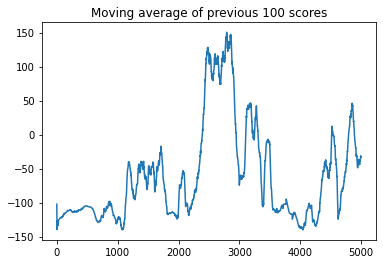

In [ ]:
#     manage_memory()
env = gym.make('BipedalWalker-v3')
agent = Agent(inputShape=env.observation_space.shape, env=env,actionsNumber=env.action_space.shape[0], alpha=0.0001, beta=0.001)
gamesNumber = 5000

plotFile = 'plot_ddpg.png'

bestScore = env.reward_range[0]
historyScores = []
checkpoint = False

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(gamesNumber):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore
        if not checkpoint:
            agent.save()

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

if not checkpoint:
    x = [i+1 for i in range(gamesNumber)]
    plot(x, historyScores, plotFile)

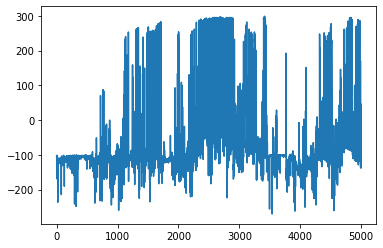

In [ ]:
plt.plot(historyScores)
plt.show()

In [ ]:
checkpoint = True

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(1):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation
    env.close()


load models


# Random Agent for BipedalWalker

episode 0 score -114.5 avg score -114.5
episode 1 score -113.9 avg score -114.2
episode 2 score -104.4 avg score -110.9
episode 3 score -105.3 avg score -109.5
episode 4 score -98.4 avg score -107.3
episode 5 score -125.7 avg score -110.4
episode 6 score -77.3 avg score -105.6
episode 7 score -115.3 avg score -106.8
episode 8 score -99.5 avg score -106.0
episode 9 score -83.3 avg score -103.7
episode 10 score -101.7 avg score -103.6
episode 11 score -116.4 avg score -104.6
episode 12 score -102.6 avg score -104.5
episode 13 score -90.5 avg score -103.5
episode 14 score -97.1 avg score -103.0
episode 15 score -102.8 avg score -103.0
episode 16 score -78.3 avg score -101.6
episode 17 score -99.2 avg score -101.4
episode 18 score -100.1 avg score -101.4
episode 19 score -102.2 avg score -101.4
episode 20 score -87.2 avg score -100.7
episode 21 score -117.6 avg score -101.5
episode 22 score -81.7 avg score -100.6
episode 23 score -125.8 avg score -101.7
episode 24 score -106.3 avg score -1

episode 208 score -85.9 avg score -97.8
episode 209 score -79.0 avg score -97.6
episode 210 score -81.8 avg score -97.4
episode 211 score -107.3 avg score -97.3
episode 212 score -100.8 avg score -97.4
episode 213 score -81.4 avg score -97.3
episode 214 score -103.8 avg score -97.5
episode 215 score -87.4 avg score -97.3
episode 216 score -98.1 avg score -97.1
episode 217 score -119.4 avg score -97.5
episode 218 score -104.2 avg score -97.5
episode 219 score -111.3 avg score -97.8
episode 220 score -72.6 avg score -97.5
episode 221 score -105.0 avg score -97.8
episode 222 score -104.3 avg score -98.0
episode 223 score -83.3 avg score -98.0
episode 224 score -116.9 avg score -98.1
episode 225 score -111.3 avg score -98.4
episode 226 score -100.6 avg score -98.5
episode 227 score -77.6 avg score -98.1
episode 228 score -103.4 avg score -98.3
episode 229 score -104.1 avg score -98.2
episode 230 score -112.6 avg score -98.4
episode 231 score -82.0 avg score -98.5
episode 232 score -70.5 av

episode 412 score -81.5 avg score -100.7
episode 413 score -107.3 avg score -100.8
episode 414 score -114.8 avg score -100.9
episode 415 score -100.2 avg score -101.1
episode 416 score -100.7 avg score -101.0
episode 417 score -117.2 avg score -101.0
episode 418 score -89.5 avg score -100.8
episode 419 score -82.9 avg score -100.6
episode 420 score -118.3 avg score -100.6
episode 421 score -101.3 avg score -100.8
episode 422 score -119.7 avg score -101.1
episode 423 score -83.7 avg score -100.7
episode 424 score -95.5 avg score -100.6
episode 425 score -107.1 avg score -100.7
episode 426 score -108.6 avg score -100.8
episode 427 score -102.2 avg score -101.0
episode 428 score -106.0 avg score -101.1
episode 429 score -101.8 avg score -101.0
episode 430 score -85.5 avg score -100.8
episode 431 score -85.0 avg score -100.5
episode 432 score -131.1 avg score -100.6
episode 433 score -100.4 avg score -100.8
episode 434 score -111.7 avg score -100.8
episode 435 score -106.5 avg score -100.7

episode 621 score -86.4 avg score -100.1
episode 622 score -96.9 avg score -99.8
episode 623 score -112.9 avg score -99.8
episode 624 score -77.8 avg score -99.4
episode 625 score -113.7 avg score -99.6
episode 626 score -98.5 avg score -99.5
episode 627 score -79.5 avg score -99.5
episode 628 score -116.5 avg score -99.7
episode 629 score -80.8 avg score -99.4
episode 630 score -117.2 avg score -99.5
episode 631 score -117.3 avg score -99.6
episode 632 score -105.0 avg score -99.8
episode 633 score -118.5 avg score -100.1
episode 634 score -87.3 avg score -99.9
episode 635 score -80.9 avg score -99.9
episode 636 score -113.9 avg score -100.1
episode 637 score -76.6 avg score -99.8
episode 638 score -99.0 avg score -99.7
episode 639 score -79.3 avg score -99.7
episode 640 score -100.5 avg score -99.5
episode 641 score -115.8 avg score -99.6
episode 642 score -96.1 avg score -99.5
episode 643 score -101.2 avg score -99.3
episode 644 score -95.2 avg score -99.3
episode 645 score -78.0 av

episode 828 score -98.8 avg score -99.0
episode 829 score -109.7 avg score -99.1
episode 830 score -103.0 avg score -99.1
episode 831 score -101.5 avg score -99.2
episode 832 score -80.8 avg score -99.1
episode 833 score -100.2 avg score -99.1
episode 834 score -112.1 avg score -99.1
episode 835 score -115.4 avg score -99.2
episode 836 score -124.9 avg score -99.6
episode 837 score -85.2 avg score -99.5
episode 838 score -104.6 avg score -99.5
episode 839 score -81.6 avg score -99.3
episode 840 score -108.7 avg score -99.2
episode 841 score -101.0 avg score -99.2
episode 842 score -118.6 avg score -99.6
episode 843 score -82.9 avg score -99.4
episode 844 score -87.5 avg score -99.3
episode 845 score -98.3 avg score -99.4
episode 846 score -84.4 avg score -99.0
episode 847 score -117.3 avg score -99.0
episode 848 score -88.2 avg score -99.2
episode 849 score -111.5 avg score -99.2
episode 850 score -100.3 avg score -99.1
episode 851 score -96.3 avg score -99.0
episode 852 score -106.3 a

episode 1030 score -77.5 avg score -99.5
episode 1031 score -108.4 avg score -99.7
episode 1032 score -76.2 avg score -99.7
episode 1033 score -118.2 avg score -99.8
episode 1034 score -114.4 avg score -99.8
episode 1035 score -88.1 avg score -99.5
episode 1036 score -98.8 avg score -99.7
episode 1037 score -87.1 avg score -99.5
episode 1038 score -78.1 avg score -99.3
episode 1039 score -81.8 avg score -99.2
episode 1040 score -84.8 avg score -98.7
episode 1041 score -103.0 avg score -98.7
episode 1042 score -100.9 avg score -98.7
episode 1043 score -99.9 avg score -98.8
episode 1044 score -84.9 avg score -98.7
episode 1045 score -100.7 avg score -98.8
episode 1046 score -97.2 avg score -98.8
episode 1047 score -99.0 avg score -98.6
episode 1048 score -77.2 avg score -98.4
episode 1049 score -80.7 avg score -98.3
episode 1050 score -78.3 avg score -98.2
episode 1051 score -101.6 avg score -98.4
episode 1052 score -99.8 avg score -98.3
episode 1053 score -99.0 avg score -98.4
episode 1

episode 1229 score -80.3 avg score -98.5
episode 1230 score -118.0 avg score -98.7
episode 1231 score -127.0 avg score -98.9
episode 1232 score -80.0 avg score -98.5
episode 1233 score -108.8 avg score -98.8
episode 1234 score -104.4 avg score -99.1
episode 1235 score -105.4 avg score -98.9
episode 1236 score -99.9 avg score -98.9
episode 1237 score -98.8 avg score -98.9
episode 1238 score -79.7 avg score -98.6
episode 1239 score -116.9 avg score -98.5
episode 1240 score -102.5 avg score -98.7
episode 1241 score -104.1 avg score -99.0
episode 1242 score -98.8 avg score -98.9
episode 1243 score -104.6 avg score -99.0
episode 1244 score -120.1 avg score -99.5
episode 1245 score -115.3 avg score -99.6
episode 1246 score -99.8 avg score -99.7
episode 1247 score -85.1 avg score -99.6
episode 1248 score -102.1 avg score -99.7
episode 1249 score -101.2 avg score -99.8
episode 1250 score -78.9 avg score -99.5
episode 1251 score -116.8 avg score -99.6
episode 1252 score -78.7 avg score -99.2
ep

episode 1430 score -98.8 avg score -101.6
episode 1431 score -100.0 avg score -101.7
episode 1432 score -85.3 avg score -101.7
episode 1433 score -81.6 avg score -101.7
episode 1434 score -84.0 avg score -101.5
episode 1435 score -89.8 avg score -101.3
episode 1436 score -103.0 avg score -101.3
episode 1437 score -117.1 avg score -101.4
episode 1438 score -110.9 avg score -101.5
episode 1439 score -77.0 avg score -101.5
episode 1440 score -111.7 avg score -101.7
episode 1441 score -105.9 avg score -101.7
episode 1442 score -117.7 avg score -101.8
episode 1443 score -84.0 avg score -101.6
episode 1444 score -103.9 avg score -101.6
episode 1445 score -109.1 avg score -101.9
episode 1446 score -101.0 avg score -101.8
episode 1447 score -80.9 avg score -101.6
episode 1448 score -102.0 avg score -101.6
episode 1449 score -101.4 avg score -101.6
episode 1450 score -81.0 avg score -101.4
episode 1451 score -104.7 avg score -101.7
episode 1452 score -103.9 avg score -101.9
episode 1453 score -

episode 1626 score -80.8 avg score -99.5
episode 1627 score -99.7 avg score -99.4
episode 1628 score -103.3 avg score -99.5
episode 1629 score -99.3 avg score -99.3
episode 1630 score -115.6 avg score -99.4
episode 1631 score -85.1 avg score -99.4
episode 1632 score -113.7 avg score -99.5
episode 1633 score -113.6 avg score -99.8
episode 1634 score -119.3 avg score -100.0
episode 1635 score -112.1 avg score -100.1
episode 1636 score -105.3 avg score -100.1
episode 1637 score -78.2 avg score -99.7
episode 1638 score -84.4 avg score -99.7
episode 1639 score -104.4 avg score -99.6
episode 1640 score -82.8 avg score -99.4
episode 1641 score -100.9 avg score -99.4
episode 1642 score -119.7 avg score -99.6
episode 1643 score -101.5 avg score -99.7
episode 1644 score -103.0 avg score -99.7
episode 1645 score -101.2 avg score -100.0
episode 1646 score -119.0 avg score -100.4
episode 1647 score -82.1 avg score -100.2
episode 1648 score -100.0 avg score -100.4
episode 1649 score -120.9 avg score

episode 1826 score -81.4 avg score -95.4
episode 1827 score -83.7 avg score -95.2
episode 1828 score -109.9 avg score -95.1
episode 1829 score -98.7 avg score -95.0
episode 1830 score -100.3 avg score -95.3
episode 1831 score -110.9 avg score -95.6
episode 1832 score -93.8 avg score -95.7
episode 1833 score -113.2 avg score -96.0
episode 1834 score -73.8 avg score -95.9
episode 1835 score -114.1 avg score -96.0
episode 1836 score -104.2 avg score -96.1
episode 1837 score -102.3 avg score -96.2
episode 1838 score -101.8 avg score -96.1
episode 1839 score -87.4 avg score -95.8
episode 1840 score -116.1 avg score -95.9
episode 1841 score -103.5 avg score -96.2
episode 1842 score -99.2 avg score -96.2
episode 1843 score -103.8 avg score -95.9
episode 1844 score -100.1 avg score -95.8
episode 1845 score -104.2 avg score -95.8
episode 1846 score -75.1 avg score -95.6
episode 1847 score -102.4 avg score -95.8
episode 1848 score -76.1 avg score -95.8
episode 1849 score -104.8 avg score -95.9
e

episode 2026 score -76.3 avg score -97.9
episode 2027 score -110.4 avg score -98.0
episode 2028 score -109.8 avg score -98.0
episode 2029 score -73.5 avg score -97.7
episode 2030 score -121.4 avg score -98.1
episode 2031 score -107.5 avg score -98.3
episode 2032 score -111.4 avg score -98.3
episode 2033 score -103.7 avg score -98.2
episode 2034 score -99.4 avg score -98.0
episode 2035 score -107.8 avg score -98.1
episode 2036 score -98.6 avg score -98.0
episode 2037 score -101.1 avg score -97.9
episode 2038 score -76.4 avg score -97.5
episode 2039 score -101.1 avg score -97.6
episode 2040 score -104.7 avg score -97.6
episode 2041 score -116.9 avg score -97.9
episode 2042 score -86.9 avg score -97.7
episode 2043 score -111.0 avg score -97.7
episode 2044 score -98.7 avg score -97.7
episode 2045 score -130.7 avg score -98.2
episode 2046 score -104.9 avg score -98.1
episode 2047 score -111.8 avg score -98.1
episode 2048 score -115.1 avg score -98.2
episode 2049 score -99.7 avg score -98.0


episode 2228 score -81.6 avg score -98.4
episode 2229 score -81.0 avg score -98.4
episode 2230 score -112.7 avg score -98.5
episode 2231 score -99.9 avg score -98.4
episode 2232 score -73.3 avg score -98.0
episode 2233 score -100.9 avg score -97.8
episode 2234 score -111.0 avg score -97.7
episode 2235 score -101.7 avg score -98.0
episode 2236 score -112.3 avg score -97.9
episode 2237 score -117.2 avg score -98.3
episode 2238 score -102.6 avg score -98.3
episode 2239 score -86.9 avg score -98.3
episode 2240 score -84.5 avg score -98.0
episode 2241 score -101.1 avg score -98.0
episode 2242 score -77.7 avg score -97.8
episode 2243 score -90.4 avg score -97.7
episode 2244 score -101.2 avg score -97.8
episode 2245 score -124.2 avg score -98.1
episode 2246 score -107.1 avg score -98.1
episode 2247 score -80.8 avg score -98.0
episode 2248 score -103.2 avg score -98.0
episode 2249 score -96.5 avg score -97.9
episode 2250 score -105.0 avg score -98.1
episode 2251 score -99.4 avg score -98.0
epi

episode 2433 score -85.4 avg score -101.2
episode 2434 score -103.3 avg score -101.3
episode 2435 score -112.5 avg score -101.3
episode 2436 score -108.7 avg score -101.3
episode 2437 score -74.8 avg score -101.1
episode 2438 score -112.9 avg score -101.0
episode 2439 score -73.0 avg score -100.9
episode 2440 score -99.9 avg score -100.9
episode 2441 score -83.3 avg score -100.7
episode 2442 score -99.7 avg score -100.7
episode 2443 score -78.3 avg score -100.7
episode 2444 score -83.2 avg score -100.4
episode 2445 score -104.2 avg score -100.7
episode 2446 score -99.6 avg score -100.8
episode 2447 score -105.0 avg score -100.7
episode 2448 score -105.2 avg score -100.9
episode 2449 score -111.3 avg score -101.2
episode 2450 score -105.4 avg score -101.1
episode 2451 score -87.0 avg score -101.0
episode 2452 score -105.0 avg score -100.9
episode 2453 score -116.8 avg score -101.1
episode 2454 score -106.5 avg score -101.1
episode 2455 score -76.6 avg score -100.5
episode 2456 score -76

episode 2627 score -80.8 avg score -100.1
episode 2628 score -113.4 avg score -100.1
episode 2629 score -83.8 avg score -99.9
episode 2630 score -97.4 avg score -100.0
episode 2631 score -98.9 avg score -100.3
episode 2632 score -121.3 avg score -100.3
episode 2633 score -89.2 avg score -100.2
episode 2634 score -100.4 avg score -100.2
episode 2635 score -99.1 avg score -100.4
episode 2636 score -97.8 avg score -100.2
episode 2637 score -99.7 avg score -100.2
episode 2638 score -110.4 avg score -100.1
episode 2639 score -117.6 avg score -100.0
episode 2640 score -120.4 avg score -100.1
episode 2641 score -101.8 avg score -100.3
episode 2642 score -99.9 avg score -100.2
episode 2643 score -107.3 avg score -100.4
episode 2644 score -87.6 avg score -100.2
episode 2645 score -98.9 avg score -100.0
episode 2646 score -112.2 avg score -100.2
episode 2647 score -104.0 avg score -100.2
episode 2648 score -101.7 avg score -100.4
episode 2649 score -100.3 avg score -100.0
episode 2650 score -88.

episode 2838 score -76.5 avg score -101.0
episode 2839 score -100.2 avg score -100.9
episode 2840 score -89.0 avg score -100.6
episode 2841 score -95.4 avg score -100.7
episode 2842 score -100.9 avg score -100.9
episode 2843 score -117.0 avg score -101.3
episode 2844 score -113.8 avg score -101.2
episode 2845 score -90.9 avg score -101.1
episode 2846 score -114.2 avg score -101.5
episode 2847 score -101.2 avg score -101.5
episode 2848 score -84.1 avg score -101.5
episode 2849 score -99.9 avg score -101.7
episode 2850 score -105.9 avg score -101.9
episode 2851 score -103.5 avg score -101.9
episode 2852 score -80.6 avg score -101.6
episode 2853 score -110.4 avg score -101.8
episode 2854 score -77.1 avg score -101.7
episode 2855 score -83.8 avg score -101.6
episode 2856 score -111.6 avg score -101.6
episode 2857 score -86.2 avg score -101.4
episode 2858 score -104.2 avg score -101.7
episode 2859 score -91.3 avg score -101.5
episode 2860 score -92.9 avg score -101.5
episode 2861 score -82.

episode 3049 score -101.2 avg score -100.9
episode 3050 score -105.6 avg score -101.0
episode 3051 score -106.2 avg score -100.9
episode 3052 score -120.4 avg score -101.1
episode 3053 score -82.7 avg score -101.0
episode 3054 score -101.1 avg score -101.0
episode 3055 score -109.4 avg score -101.3
episode 3056 score -116.0 avg score -101.5
episode 3057 score -119.9 avg score -101.7
episode 3058 score -85.1 avg score -101.5
episode 3059 score -73.8 avg score -101.2
episode 3060 score -116.2 avg score -101.1
episode 3061 score -105.2 avg score -101.4
episode 3062 score -121.4 avg score -101.8
episode 3063 score -102.3 avg score -101.8
episode 3064 score -88.3 avg score -101.6
episode 3065 score -115.7 avg score -101.8
episode 3066 score -103.6 avg score -102.0
episode 3067 score -105.6 avg score -102.3
episode 3068 score -111.0 avg score -102.5
episode 3069 score -102.9 avg score -102.4
episode 3070 score -83.5 avg score -102.1
episode 3071 score -84.9 avg score -102.1
episode 3072 scor

episode 3246 score -79.4 avg score -99.6
episode 3247 score -89.5 avg score -99.4
episode 3248 score -124.5 avg score -99.6
episode 3249 score -85.8 avg score -99.7
episode 3250 score -78.6 avg score -99.6
episode 3251 score -101.5 avg score -99.6
episode 3252 score -101.6 avg score -99.7
episode 3253 score -76.4 avg score -99.5
episode 3254 score -113.8 avg score -99.6
episode 3255 score -116.9 avg score -99.7
episode 3256 score -100.4 avg score -99.5
episode 3257 score -99.7 avg score -99.3
episode 3258 score -102.3 avg score -99.2
episode 3259 score -100.7 avg score -99.3
episode 3260 score -130.6 avg score -99.5
episode 3261 score -95.4 avg score -99.3
episode 3262 score -82.5 avg score -99.1
episode 3263 score -108.3 avg score -99.3
episode 3264 score -100.2 avg score -99.5
episode 3265 score -98.4 avg score -99.4
episode 3266 score -78.4 avg score -99.3
episode 3267 score -102.0 avg score -99.5
episode 3268 score -111.7 avg score -99.6
episode 3269 score -103.6 avg score -99.8
ep

episode 3454 score -93.9 avg score -97.8
episode 3455 score -115.2 avg score -97.9
episode 3456 score -92.3 avg score -98.0
episode 3457 score -103.8 avg score -98.2
episode 3458 score -86.2 avg score -98.2
episode 3459 score -102.6 avg score -98.0
episode 3460 score -99.1 avg score -98.1
episode 3461 score -104.7 avg score -98.3
episode 3462 score -98.4 avg score -98.3
episode 3463 score -104.7 avg score -98.2
episode 3464 score -104.3 avg score -98.3
episode 3465 score -113.5 avg score -98.5
episode 3466 score -108.6 avg score -98.4
episode 3467 score -86.3 avg score -98.5
episode 3468 score -91.5 avg score -98.4
episode 3469 score -97.4 avg score -98.4
episode 3470 score -109.7 avg score -98.6
episode 3471 score -112.9 avg score -98.9
episode 3472 score -109.8 avg score -99.1
episode 3473 score -98.0 avg score -99.1
episode 3474 score -102.5 avg score -99.4
episode 3475 score -88.8 avg score -99.3
episode 3476 score -101.8 avg score -99.2
episode 3477 score -164.8 avg score -100.1
e

episode 3655 score -81.1 avg score -99.6
episode 3656 score -117.9 avg score -99.6
episode 3657 score -83.0 avg score -99.3
episode 3658 score -118.1 avg score -99.5
episode 3659 score -92.2 avg score -99.4
episode 3660 score -94.0 avg score -99.1
episode 3661 score -98.6 avg score -99.3
episode 3662 score -73.6 avg score -99.0
episode 3663 score -77.2 avg score -98.7
episode 3664 score -72.1 avg score -98.5
episode 3665 score -100.2 avg score -98.5
episode 3666 score -75.9 avg score -98.2
episode 3667 score -77.1 avg score -98.0
episode 3668 score -98.3 avg score -98.1
episode 3669 score -100.0 avg score -97.9
episode 3670 score -106.3 avg score -98.1
episode 3671 score -125.0 avg score -98.4
episode 3672 score -104.4 avg score -98.2
episode 3673 score -101.7 avg score -98.1
episode 3674 score -106.5 avg score -98.1
episode 3675 score -102.0 avg score -98.1
episode 3676 score -89.4 avg score -97.7
episode 3677 score -102.3 avg score -97.7
episode 3678 score -100.3 avg score -97.7
epis

episode 3854 score -101.0 avg score -98.6
episode 3855 score -104.1 avg score -98.6
episode 3856 score -114.7 avg score -98.9
episode 3857 score -97.2 avg score -98.7
episode 3858 score -105.6 avg score -98.5
episode 3859 score -76.8 avg score -98.5
episode 3860 score -112.5 avg score -98.6
episode 3861 score -98.3 avg score -98.3
episode 3862 score -72.6 avg score -97.9
episode 3863 score -102.7 avg score -98.1
episode 3864 score -109.4 avg score -98.0
episode 3865 score -105.9 avg score -98.0
episode 3866 score -81.4 avg score -98.0
episode 3867 score -114.6 avg score -98.2
episode 3868 score -112.2 avg score -98.2
episode 3869 score -98.1 avg score -98.3
episode 3870 score -76.3 avg score -98.1
episode 3871 score -86.9 avg score -98.2
episode 3872 score -121.4 avg score -98.6
episode 3873 score -111.1 avg score -99.0
episode 3874 score -100.1 avg score -98.8
episode 3875 score -112.4 avg score -98.8
episode 3876 score -77.6 avg score -98.6
episode 3877 score -100.6 avg score -98.4
e

episode 4052 score -79.9 avg score -101.6
episode 4053 score -107.6 avg score -101.8
episode 4054 score -103.1 avg score -101.8
episode 4055 score -102.4 avg score -101.8
episode 4056 score -75.0 avg score -101.4
episode 4057 score -106.7 avg score -101.5
episode 4058 score -101.0 avg score -101.4
episode 4059 score -86.8 avg score -101.2
episode 4060 score -85.3 avg score -101.0
episode 4061 score -107.9 avg score -101.0
episode 4062 score -99.4 avg score -101.1
episode 4063 score -90.1 avg score -101.0
episode 4064 score -100.2 avg score -100.8
episode 4065 score -114.9 avg score -101.2
episode 4066 score -89.0 avg score -101.1
episode 4067 score -77.7 avg score -100.8
episode 4068 score -122.5 avg score -101.1
episode 4069 score -72.7 avg score -100.9
episode 4070 score -112.2 avg score -101.0
episode 4071 score -106.0 avg score -101.2
episode 4072 score -119.5 avg score -101.4
episode 4073 score -109.1 avg score -101.3
episode 4074 score -113.6 avg score -101.6
episode 4075 score -

episode 4248 score -102.3 avg score -96.9
episode 4249 score -107.2 avg score -97.2
episode 4250 score -122.0 avg score -97.4
episode 4251 score -108.2 avg score -97.6
episode 4252 score -75.2 avg score -97.6
episode 4253 score -97.3 avg score -97.4
episode 4254 score -78.0 avg score -97.3
episode 4255 score -101.8 avg score -97.5
episode 4256 score -97.9 avg score -97.2
episode 4257 score -85.5 avg score -97.3
episode 4258 score -89.7 avg score -97.1
episode 4259 score -89.7 avg score -97.1
episode 4260 score -97.1 avg score -97.1
episode 4261 score -103.2 avg score -96.9
episode 4262 score -87.5 avg score -96.8
episode 4263 score -117.8 avg score -96.9
episode 4264 score -108.4 avg score -96.9
episode 4265 score -99.0 avg score -96.9
episode 4266 score -101.3 avg score -96.9
episode 4267 score -102.7 avg score -97.0
episode 4268 score -102.1 avg score -97.2
episode 4269 score -100.8 avg score -97.1
episode 4270 score -102.1 avg score -97.2
episode 4271 score -99.7 avg score -97.4
epi

episode 4453 score -103.2 avg score -101.5
episode 4454 score -104.7 avg score -101.8
episode 4455 score -118.2 avg score -102.0
episode 4456 score -99.5 avg score -101.7
episode 4457 score -97.1 avg score -101.7
episode 4458 score -87.9 avg score -101.5
episode 4459 score -111.2 avg score -101.8
episode 4460 score -98.2 avg score -101.7
episode 4461 score -79.1 avg score -101.4
episode 4462 score -117.5 avg score -101.5
episode 4463 score -87.6 avg score -101.6
episode 4464 score -116.3 avg score -101.8
episode 4465 score -102.5 avg score -101.8
episode 4466 score -99.5 avg score -101.9
episode 4467 score -122.2 avg score -102.0
episode 4468 score -101.5 avg score -102.0
episode 4469 score -106.8 avg score -102.1
episode 4470 score -94.4 avg score -102.2
episode 4471 score -100.1 avg score -102.2
episode 4472 score -83.4 avg score -102.2
episode 4473 score -105.7 avg score -102.2
episode 4474 score -102.7 avg score -102.2
episode 4475 score -121.2 avg score -102.2
episode 4476 score -

episode 4649 score -78.7 avg score -99.1
episode 4650 score -99.9 avg score -99.1
episode 4651 score -81.0 avg score -98.8
episode 4652 score -99.5 avg score -98.8
episode 4653 score -120.9 avg score -99.0
episode 4654 score -99.2 avg score -98.9
episode 4655 score -118.5 avg score -99.1
episode 4656 score -76.7 avg score -98.8
episode 4657 score -196.5 avg score -99.8
episode 4658 score -77.9 avg score -99.8
episode 4659 score -77.5 avg score -99.5
episode 4660 score -105.5 avg score -99.8
episode 4661 score -124.7 avg score -99.8
episode 4662 score -87.0 avg score -99.5
episode 4663 score -99.1 avg score -99.5
episode 4664 score -113.2 avg score -99.7
episode 4665 score -104.1 avg score -99.6
episode 4666 score -80.7 avg score -99.4
episode 4667 score -105.3 avg score -99.8
episode 4668 score -89.9 avg score -99.7
episode 4669 score -103.3 avg score -99.7
episode 4670 score -81.9 avg score -99.6
episode 4671 score -88.2 avg score -99.5
episode 4672 score -78.9 avg score -99.5
episode

episode 4849 score -79.1 avg score -99.3
episode 4850 score -104.2 avg score -99.2
episode 4851 score -83.5 avg score -99.0
episode 4852 score -89.9 avg score -98.9
episode 4853 score -99.8 avg score -98.7
episode 4854 score -91.6 avg score -98.5
episode 4855 score -79.3 avg score -98.4
episode 4856 score -102.1 avg score -98.4
episode 4857 score -117.4 avg score -98.8
episode 4858 score -102.8 avg score -98.8
episode 4859 score -116.0 avg score -99.1
episode 4860 score -93.2 avg score -99.1
episode 4861 score -112.4 avg score -99.2
episode 4862 score -104.6 avg score -99.1
episode 4863 score -82.8 avg score -98.8
episode 4864 score -100.4 avg score -99.0
episode 4865 score -85.6 avg score -99.1
episode 4866 score -91.2 avg score -99.2
episode 4867 score -106.8 avg score -99.4
episode 4868 score -96.2 avg score -99.4
episode 4869 score -95.4 avg score -99.3
episode 4870 score -105.6 avg score -99.7
episode 4871 score -101.0 avg score -99.6
episode 4872 score -77.2 avg score -99.5
episo

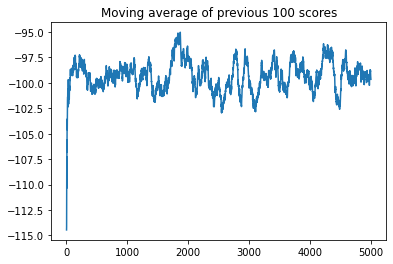

In [ ]:
env = gym.make('BipedalWalker-v3')
actionSize = env.action_space.shape[0]

gamesNumber = 5000

plotFile = 'plot_random.png'

bestScore = env.reward_range[0]
historyScores = []

for i in range(gamesNumber):
    env.reset()
    done = False
    score = 0
    while not done:
        action = np.random.uniform(-1.0, 1.0, size=actionSize)
        observation_, reward, done, info = env.step(action)
        score += reward

        if done:
            break

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

x = [i+1 for i in range(gamesNumber)]
plot(x, historyScores, plotFile)

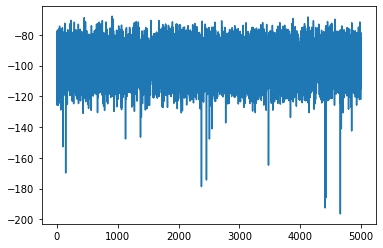

In [ ]:
plt.plot(historyScores)
plt.show()

In [ ]:
from gym import wrappers

env = gym.make('BipedalWalker-v3')
env = wrappers.Monitor(env, "./gym-results_random", force=True)
env.reset()

done = False
score = 0
while not done:
    action = np.random.uniform(-1.0, 1.0, size=actionSize)
    observation_, reward, done, info = env.step(action)
    score += reward
    if done:
        env.close()
        break
